## Multi-label classification

In [1]:
# !mkdir -p /root/data/plant_seedlings
# kaggle competitions download -c plant-seedlings-classification

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *

In [7]:
PATH = '/root/notebooks/data_small/plant_seedlings' # See Dir.Organization.ipynb for how this was split (%20 random)

In [8]:
!ls {PATH}

sample_submission.csv  test  train  valid


In [9]:
from planet import f2

# metrics=[f2]
f_model = resnet34

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [10]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

In [11]:
# def get_data(sz):
#     tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
#     return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
#                     suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [12]:
data = get_data(256)

In [13]:
x,y = next(iter(data.val_dl))

In [14]:
y


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.cuda.LongTensor of size 64 (GPU 0)]

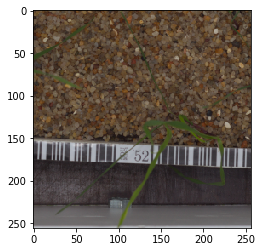

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

In [25]:
learn = ConvLearner.pretrained(f_model, data)

 95%|█████████▌| 57/60 [00:12<00:00,  4.48it/s, loss=33.8]

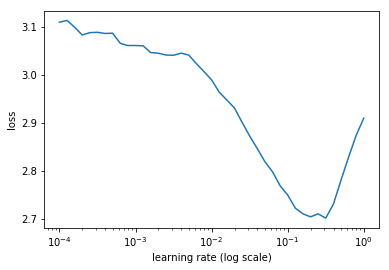

In [26]:
lrf=learn.lr_find()
learn.sched.plot()

In [27]:
lr = 0.1

In [29]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.83013    1.28086    0.561774  
    1      1.755567   1.209044   0.592397                 
    2      1.513439   1.13506    0.609293                 
    3      1.471853   1.186736   0.589229                 
    4      1.380547   1.087769   0.61774                  
    5      1.31617    1.04614    0.636748                 
    6      1.22794    1.026222   0.644139                 


[array([1.02622]), 0.6441393883578251]

 95%|█████████▌| 57/60 [00:12<00:00,  4.57it/s, loss=20.2]

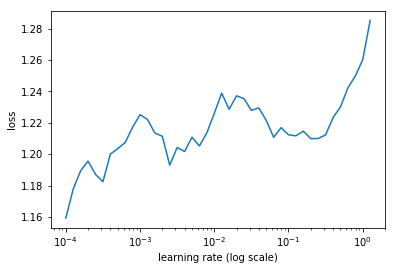

In [30]:
lrf=learn.lr_find()
learn.sched.plot()

In [31]:
data = get_data(256)

In [32]:
data = data.resize(int(256), 'tmp')

In [33]:
lrs=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

# Checking out the model
### Let's check out some bad performers, good performers and see the test set performance

## Let's check out the good and the bad

In [33]:
def explore_image(img_num, df):
    datapath = 'data/planet/train-jpg/'
    img_path = os.path.join(datapath, f'train_{img_num}.jpg')
    img = plt.imread(img_path)
    plt.imshow(img*2)
    plt.figure(2)
    plt.imshow(img*3)
    print(df.loc[df['image_name'] == img_path.split('/')[-1].split('.jpg')[0]])

  image_name          tags
0    train_0  haze primary


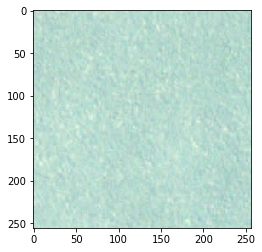

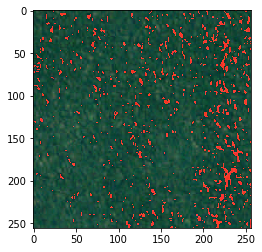

In [34]:
explore_image(0, df)

  image_name                tags
5    train_5  haze primary water


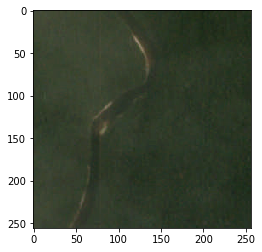

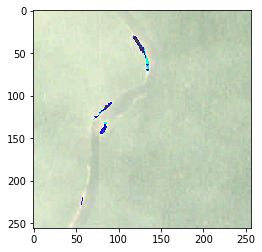

In [35]:
explore_image(5, df)

   image_name                             tags
20   train_20  agriculture clear primary water


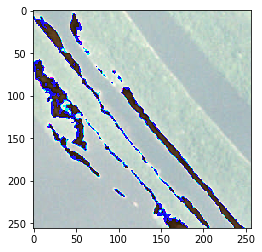

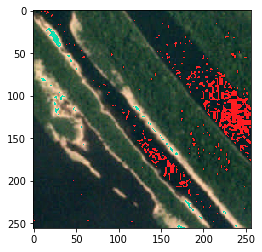

In [36]:
explore_image(20, df)

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. The most correct labels of each class (i.e. those with highest probability that are correct)
1. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
1. The most uncertain labels (i.e. those with probability closest to 0.5).

In [ ]:
# most correct labels

In [71]:
log_preds = learn.predict()
log_preds.shape

(8095, 17)

In [72]:
len(data.classes)

17

In [73]:
!ls {PATH}/train-jpg | wc

  40479   40479  636554


In [74]:
!ls {PATH}/test-jpg | wc

  61191   61191  895645


In [ ]:
40479*.20 # 20% for the validation set

In [ ]:
log_preds[0][:10]

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(os.path.join(PATH, ds.fnames[idx])))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
class_num = 1
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

In [ ]:
log_preds[0]

In [ ]:
df_submit = pd.DataFrame.from_records(log_preds)

In [ ]:
df_submit.tail()

# Test set predictions

In [75]:
log_preds = learn.predict(is_test=True)
log_preds.shape

(61191, 17)

In [76]:
!ls {PATH}/test-jpg | wc

  61191   61191  895645


In [79]:
data.test_dl.dataset.fnames[:2]

['test-jpg/test_25202.jpg', 'test-jpg/test_5717.jpg']

In [80]:
idnames = []
for filepath in data.test_dl.dataset.fnames:
    idnames.append( filepath.split('/')[-1].split('.jpg')[0])
    
idnames[:2]

['test_25202', 'test_5717']

In [83]:
headerrow = (['image_name'] + data.classes)
headerrow

['image_name',
 'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [90]:
datarows = []
for idname, testproblist in zip(idnames, log_preds):
    datarows.append([idname] + list(testproblist))

In [96]:
for row in datarows[:5]:
    print(row, '\n')

['test_25202', 0.8510828, 0.006682734, 0.018431943, 0.004219984, 0.0040858556, 0.25970513, 0.0022483885, 0.0023724153, 0.4915588, 0.11730327, 0.016370913, 0.78066945, 0.99811184, 0.18417783, 0.008944454, 0.022148922, 0.07608526] 

['test_5717', 0.6932449, 0.002218693, 0.017363638, 0.008529354, 0.005441029, 0.83849454, 0.0004837681, 0.0012323216, 0.5565229, 0.13678205, 0.013700079, 0.18819085, 0.99895096, 0.15436338, 0.02298283, 0.018494472, 0.096373454] 

['test_40598', 0.8781788, 0.0050865244, 0.03655335, 0.00068294205, 0.00067316735, 0.94674665, 0.0009372712, 0.002473171, 0.068926506, 0.053121682, 0.02111562, 0.009883429, 0.9774646, 0.38411236, 0.0016035662, 0.002427033, 0.6712714] 

['file_2096', 0.31645346, 0.0013113068, 0.009683834, 0.013142709, 0.0023444346, 0.9156312, 0.000500829, 0.000803935, 0.07359474, 0.0285347, 0.0032859675, 0.26445806, 0.99899024, 0.07770417, 0.016689517, 0.0026713323, 0.14476894] 

['file_19729', 0.23450658, 0.009330662, 0.03171017, 0.0043838536, 0.003059

In [97]:
df_submit = pd.DataFrame.from_records(datarows, columns=headerrow)

In [132]:
df_head = df_submit.head()
df_head

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_25202,0.851083,0.006683,0.018432,0.004220,0.004086,0.259705,0.002248,0.002372,0.491559,0.117303,0.016371,0.780669,0.998112,0.184178,0.008944,0.022149,0.076085
1,test_5717,0.693245,0.002219,0.017364,0.008529,0.005441,0.838495,0.000484,0.001232,0.556523,0.136782,0.013700,0.188191,0.998951,0.154363,0.022983,0.018494,0.096373
2,test_40598,0.878179,0.005087,0.036553,0.000683,0.000673,0.946747,0.000937,0.002473,0.068927,0.053122,0.021116,0.009883,0.977465,0.384112,0.001604,0.002427,0.671271
3,file_2096,0.316453,0.001311,0.009684,0.013143,0.002344,0.915631,0.000501,0.000804,0.073595,0.028535,0.003286,0.264458,0.998990,0.077704,0.016690,0.002671,0.144769
4,file_19729,0.234507,0.009331,0.031710,0.004384,0.003060,0.092847,0.003302,0.003250,0.130110,0.033286,0.005356,0.910569,0.993820,0.193541,0.008064,0.004475,0.152647


# Get this into the submission format


'image_name'

In [159]:
all_rows = []

def convert_submission_format(df_head):
    for index, row in df_head.iterrows():
        results = ' '.join([df_head.columns[indx+1] for indx, col in enumerate(row.values[1:]) if float(col) > .5])
    #     for indx, col in enumerate(row.values[1:]):
    #         if float(col) > .5:
    #             results.append(df_head.columns[indx+1])
        image_name = row.values[0]
        all_rows.append([image_name, results])
    # image_name, results
    all_rows

    submission_df = pd.DataFrame.from_records(all_rows, columns=['image_name', 'tags'])
    return submission_df

In [161]:
converted_for_subm_df = convert_submission_format(df_submit)

In [164]:
converted_for_subm_df.shape

(61191, 2)

In [166]:
converted_for_subm_df.to_csv('big_ol_clips_good_model_88perc_validation.csv', index=False)

In [130]:
water_df = df_submit[df_submit['water'] > .5]
water_df[water_df['cultivation'] > .6]

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
37348,file_19150,0.72114,0.136024,0.197743,0.011325,0.027026,0.982311,0.006352,0.048102,0.633492,0.18442,0.002478,0.041262,0.985634,0.240329,0.027854,0.042796,0.553357


In [122]:
df_filtered = df_submit[df_submit['agriculture'] > .8]
df_filtered.index[3]

26

In [84]:
%time test_log_preds, test_y = learn.TTA()

CPU times: user 36.8 s, sys: 9.66 s, total: 46.4 s
Wall time: 26.4 s


In [88]:
mean_test_log_preds = np.mean(test_log_preds, 0)
f2(mean_test_log_preds, test_y)
# .883 didn't really help the model over previous ~.88

0.8834438659983926

# Further training

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

# Let's take a look at the data performance

# One more size upgrade and final training

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

### End